In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from transformers import ViTForImageClassification

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data transformation
data_transformation = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
])

In [4]:
# Define train, test, and validation directories
train_dir = "/content/drive/MyDrive/pyrack/data/train"
test_dir = "/content/drive/MyDrive/pyrack/data/test"
val_dir = "/content/drive/MyDrive/pyrack/data/valid"

# Load image datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transformation)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transformation)

In [6]:
# Define batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = 6

# Define number of epochs
num_epochs = 10

In [7]:
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's

train_dataloader = DataLoader(train_data,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False,
                                      num_workers=NUM_WORKERS)





train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 6 workers.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(<torch.utils.data.dataloader.DataLoader at 0x7bc39cdc05b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7bc39cdc0280>)

In [8]:
import torch
from torch import nn
import torch.optim as optim

In [9]:
# Model 1: Vision Transformer
#to convert class labels to integer indices
from transformers import ViTImageProcessor

label2id = train_data.class_to_idx
label2id

{'boots': 0,
 'flip_flops': 1,
 'loafers': 2,
 'sandals': 3,
 'sneakers': 4,
 'soccer_shoes': 5}

In [10]:
#So the indices become keys and values becomes class names
id2label = {label:id for id,label in label2id.items()}
id2label

{0: 'boots',
 1: 'flip_flops',
 2: 'loafers',
 3: 'sandals',
 4: 'sneakers',
 5: 'soccer_shoes'}

In [11]:
# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True)

# Initialize list to store MAE scores
# mae_scores = []

# Loop over folds
for fold, (train_index, val_index) in enumerate(kf.split(train_data)):
    print(f"Fold {fold + 1}:")

    # Create DataLoader for training and validation sets
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=NUM_WORKERS)
    val_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=NUM_WORKERS)

    # Initialize Vision Transformer model
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=6, id2label=id2label,label2id=label2id).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train = 0
        correct_train = 0
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
        print(f"Train Accuracy: {100.0 * correct_train/total_train: .2f}%")

   # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

Fold 1:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/10, Loss: 1.3062456515100267
Train Accuracy:  69.22%
Epoch 2/10, Loss: 0.4876798685226176
Train Accuracy:  93.37%
Epoch 3/10, Loss: 0.1938677535702785
Train Accuracy:  98.69%
Epoch 4/10, Loss: 0.10499027226534155
Train Accuracy:  99.56%
Epoch 5/10, Loss: 0.07183757610619068
Train Accuracy:  99.74%
Epoch 6/10, Loss: 0.07125050057139662
Train Accuracy:  99.30%
Epoch 7/10, Loss: 0.04653263764662875
Train Accuracy:  100.00%
Epoch 8/10, Loss: 0.031599244413276516
Train Accuracy:  100.00%
Epoch 9/10, Loss: 0.02535759512748983
Train Accuracy:  100.00%
Epoch 10/10, Loss: 0.021497278319050867
Train Accuracy:  100.00%
Test Accuracy: 83.82%
Fold 2:


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 1.3237006780174043
Train Accuracy:  69.05%
Epoch 2/10, Loss: 0.5308246604270406
Train Accuracy:  90.85%
Epoch 3/10, Loss: 0.20457417103979322
Train Accuracy:  98.78%
Epoch 4/10, Loss: 0.11348395898110336
Train Accuracy:  99.30%
Epoch 5/10, Loss: 0.06791920287327634
Train Accuracy:  99.83%
Epoch 6/10, Loss: 0.04993236240827375
Train Accuracy:  99.91%
Epoch 7/10, Loss: 0.03956701554771927
Train Accuracy:  99.91%
Epoch 8/10, Loss: 0.03307016318043073
Train Accuracy:  99.83%
Epoch 9/10, Loss: 0.028367978986352682
Train Accuracy:  99.91%
Epoch 10/10, Loss: 0.024173616172952786
Train Accuracy:  99.91%
Test Accuracy: 86.13%
Fold 3:


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 1.346226332916154
Train Accuracy:  65.30%
Epoch 2/10, Loss: 0.520735846625434
Train Accuracy:  92.50%
Epoch 3/10, Loss: 0.22639306096567047
Train Accuracy:  97.12%
Epoch 4/10, Loss: 0.1259840673042668
Train Accuracy:  99.22%
Epoch 5/10, Loss: 0.08267301972955465
Train Accuracy:  99.56%
Epoch 6/10, Loss: 0.05424130211273829
Train Accuracy:  99.83%
Epoch 7/10, Loss: 0.08983711991459131
Train Accuracy:  98.08%
Epoch 8/10, Loss: 0.0806032901422845
Train Accuracy:  98.52%
Epoch 9/10, Loss: 0.047165210669239364
Train Accuracy:  99.48%
Epoch 10/10, Loss: 0.06414862453109688
Train Accuracy:  98.43%
Test Accuracy: 84.97%
Fold 4:


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 1.315808633963267
Train Accuracy:  69.75%
Epoch 2/10, Loss: 0.4813075380192863
Train Accuracy:  94.68%
Epoch 3/10, Loss: 0.19807564839720726
Train Accuracy:  98.52%
Epoch 4/10, Loss: 0.11312946263286802
Train Accuracy:  99.22%
Epoch 5/10, Loss: 0.07715807813737127
Train Accuracy:  99.56%
Epoch 6/10, Loss: 0.05124287876403994
Train Accuracy:  99.91%
Epoch 7/10, Loss: 0.03971308148983452
Train Accuracy:  99.91%
Epoch 8/10, Loss: 0.032982607216884695
Train Accuracy:  99.91%
Epoch 9/10, Loss: 0.02902330132201314
Train Accuracy:  99.74%
Epoch 10/10, Loss: 0.024515333223260112
Train Accuracy:  99.91%
Test Accuracy: 84.97%
Fold 5:


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Loss: 1.327863719728258
Train Accuracy:  66.20%
Epoch 2/10, Loss: 0.5355580879582299
Train Accuracy:  92.86%
Epoch 3/10, Loss: 0.20850452780723572
Train Accuracy:  98.26%
Epoch 4/10, Loss: 0.10681594059699112
Train Accuracy:  99.39%
Epoch 5/10, Loss: 0.08908811987688144
Train Accuracy:  99.04%
Epoch 6/10, Loss: 0.0630600948093666
Train Accuracy:  99.56%
Epoch 7/10, Loss: 0.04225806602173381
Train Accuracy:  99.83%
Epoch 8/10, Loss: 0.033289629914280444
Train Accuracy:  99.83%
Epoch 9/10, Loss: 0.027518640272319317
Train Accuracy:  99.91%
Epoch 10/10, Loss: 0.023827339626020856
Train Accuracy:  99.91%
Test Accuracy: 87.28%


In [12]:
torch.save(model.state_dict(), "/content/drive/MyDrive/pyrack/data/Model Weights/footweartype_VIT.pth")

In [14]:
from PIL import Image
from pathlib import Path

Actual class: soccer
Predicted class: soccer


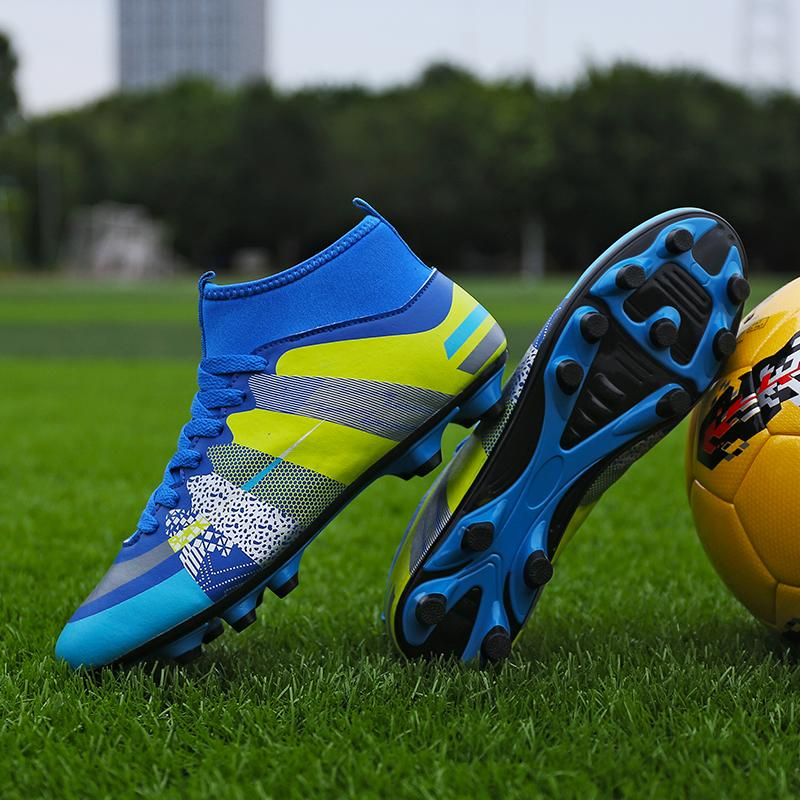

In [17]:
val_path = "/content/drive/MyDrive/pyrack/data/valid/soccer_shoes/image151.jpeg"
val_image_path = Path(val_path) #hand-picked a random image
image_class = '_'.join(val_image_path.parent.stem.split('_')[-4:]) #Change the image names
img1 = Image.open(val_image_path)
test_input = data_transformation(img1).to(device)

with torch.no_grad():
    test_img = test_input.unsqueeze(dim=0)
    logits = model(test_img).logits
predicted_label = logits.argmax(-1).item()


print(f'Actual class:',image_class.split('_')[0])
pred = model.config.id2label[predicted_label].split('_')[0]
print(f'Predicted class: {pred}')
img1